In [1]:
# upload audio file
from google.colab import files
uploaded = files.upload()
path = next(iter(uploaded))

Saving stealth.mp3 to stealth.mp3


In [2]:
num_speakers = 2 #@param {type:"integer"}

language = 'English' #@param ['any', 'English']

model_size = 'large' #@param ['tiny', 'base', 'small', 'medium', 'large']


model_name = model_size
if language == 'English' and model_size != 'large':
  model_name += '.en'

In [3]:
!pip install -q git+https://github.com/openai/whisper.git > /dev/null
!pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null

import whisper
import datetime

import subprocess

import torch
import pyannote.audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
embedding_model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib

from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [4]:
if path[-3:] != 'wav':
  subprocess.call(['ffmpeg', '-i', path, 'audio.wav', '-y'])
  path = 'audio.wav'

In [5]:
model = whisper.load_model(model_size)

100%|█████████████████████████████████████| 2.87G/2.87G [00:31<00:00, 99.0MiB/s]


In [6]:
result = model.transcribe(path)
segments = result["segments"]

In [7]:
with contextlib.closing(wave.open(path,'r')) as f:
  frames = f.getnframes()
  rate = f.getframerate()
  duration = frames / float(rate)

In [8]:
audio = Audio()

def segment_embedding(segment):
  start = segment["start"]
  # Whisper overshoots the end timestamp in the last segment
  end = min(duration, segment["end"])
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(path, clip)
  return embedding_model(waveform[None])

In [9]:
embeddings = np.zeros(shape=(len(segments), 192))
for i, segment in enumerate(segments):
  embeddings[i] = segment_embedding(segment)

embeddings = np.nan_to_num(embeddings)

In [10]:
clustering = AgglomerativeClustering(num_speakers).fit(embeddings)
labels = clustering.labels_
for i in range(len(segments)):
  segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)

In [11]:
def time(secs):
  return datetime.timedelta(seconds=round(secs))

f = open("transcript.txt", "w")
x = ""
for (i, segment) in enumerate(segments):
  if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
    f.write("\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n')
  f.write(segment["text"][1:] + ' ')
  x += "\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n'
  x += segment["text"][1:] + ' '
f.close()

In [12]:
print(open('transcript.txt').read())


SPEAKER 1 0:00:00
I would have added in the retro... 
SPEAKER 2 0:00:04
Retroreflective panels? 
SPEAKER 1 0:00:04
To make him stealth mode. You want a stealth mode? Cool, right? 
SPEAKER 2 0:00:07
That's actually a good idea. Maybe I'll build one. 


In [13]:
print(x)


SPEAKER 1 0:00:00
I would have added in the retro... 
SPEAKER 2 0:00:04
Retroreflective panels? 
SPEAKER 1 0:00:04
To make him stealth mode. 
SPEAKER 1 0:00:06
You want a stealth mode? 
SPEAKER 1 0:00:06
Cool, right? 
SPEAKER 2 0:00:07
That's actually a good idea. Maybe I'll build one. 


In [14]:
print(result)

{'text': " I would have added in the retro... Retroreflective panels? To make him stealth mode. You want a stealth mode? Cool, right? That's actually a good idea. Maybe I'll build one.", 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 3.5, 'text': ' I would have added in the retro...', 'tokens': [50364, 286, 576, 362, 3869, 294, 264, 18820, 485, 50539], 'temperature': 0.0, 'avg_logprob': -0.3701788249768709, 'compression_ratio': 1.2627737226277371, 'no_speech_prob': 0.11304232478141785, 'speaker': 'SPEAKER 1'}, {'id': 1, 'seek': 0, 'start': 3.5, 'end': 4.5, 'text': ' Retroreflective panels?', 'tokens': [50539, 11495, 340, 33115, 1809, 488, 13419, 30, 50589], 'temperature': 0.0, 'avg_logprob': -0.3701788249768709, 'compression_ratio': 1.2627737226277371, 'no_speech_prob': 0.11304232478141785, 'speaker': 'SPEAKER 2'}, {'id': 2, 'seek': 0, 'start': 4.5, 'end': 5.8, 'text': ' To make him stealth mode.', 'tokens': [50589, 1407, 652, 796, 25756, 4391, 13, 50654], 'temperature': 0.0, '

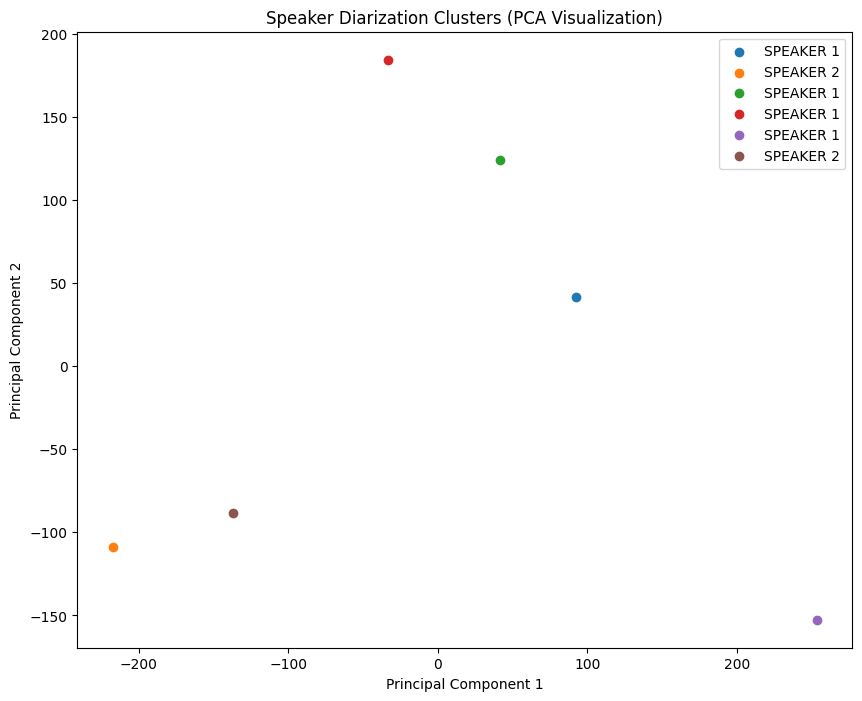

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y = embeddings_2d[i]
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}')

plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


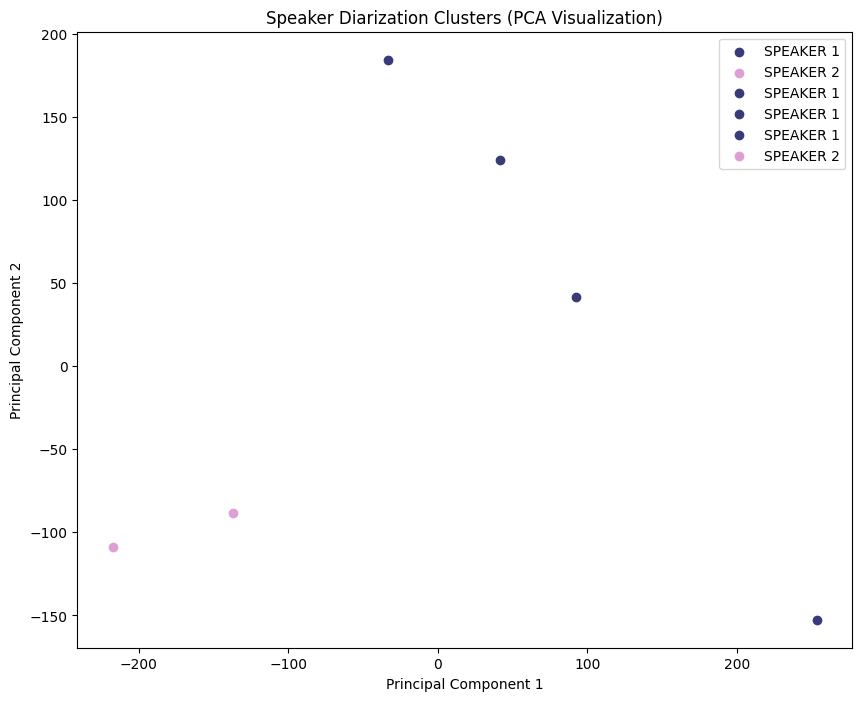

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y = embeddings_2d[i]
    color = colors[labels[i] % num_unique_speakers]  # Get the corresponding color for the speaker
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}', color=color)

plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [19]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 3D
pca = PCA(n_components=3, random_state=42)
embeddings_3d = pca.fit_transform(embeddings)

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# Prepare the data for the 3D scatter plot
data = []
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y, z = embeddings_3d[i]
    color = colors[labels[i] % num_unique_speakers]  # Get the corresponding color for the speaker
    trace = go.Scatter3d(x=[x], y=[y], z=[z], mode='markers',
                         marker=dict(size=5, color=color),
                         name=f'SPEAKER {speaker_id}')
    data.append(trace)

# Layout for the 3D scatter plot
layout = go.Layout(
    title="Speaker Diarization Clusters (3D Visualization)",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    )
)

# Create the figure and plot the 3D scatter plot
fig = go.Figure(data=data, layout=layout)
fig.show()
